<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели картинку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всего работают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/iK9ZtggjJcGKIA)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [ ]:
!nvidia-smi

Fri Feb 11 17:22:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [60]:
%matplotlib inline

DATA_PATH = '/content/gdrive/MyDrive/DLS_Project'
# DATA_PATH = '/kaggle/working'
# DATA_PATH = '/content'

# For Google Colab only:
import sys
sys.path.append(DATA_PATH)
# from reco_utils.recommender.sar.sar_singlenode import SARSingleNode
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Kaggle environment
!pip install gdown
!gdown --id 1fkJd6_zij-NfuMX-Jxb2JgCeFgD3BSjm

Downloading...
From: https://drive.google.com/uc?id=1fkJd6_zij-NfuMX-Jxb2JgCeFgD3BSjm
To: /content/beheaded_inception3.py
100% 1.81k/1.81k [00:00<00:00, 3.64MB/s]


In [2]:
!pip install -q rouge-metric

     |████████████████████████████████| 151 kB 2.8 MB/s 


In [3]:
import os
import tarfile
import numpy as np
import json
from collections import Counter, defaultdict
from tqdm.notebook import tqdm 
import functools
from itertools import chain

from torch.utils.data import Dataset, DataLoader, Sampler
import torch.utils.data
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.distributions import Categorical
from torchvision import transforms, models

from matplotlib import pyplot as plt
from IPython.display import clear_output

from skimage.transform import resize
from PIL import Image

from nltk.translate.bleu_score import corpus_bleu
from rouge_metric import PyRouge

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
if not os.path.exists(os.path.join(DATA_PATH, 'data')):
  with tarfile.open(os.path.join(DATA_PATH, 'handout.tar')) as file:
    file.extractall(DATA_PATH)

# загружаем датасет
img_codes = np.load(os.path.join(DATA_PATH, "data/image_codes.npy"))
captions = json.load(open(os.path.join(DATA_PATH, 'data/captions_tokenized.json')))

In [ ]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0, :10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить только те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлых занятиях. Батч должен выглядеть примерно так:
ВАЖНО! Почему я советую писать отдельную функцию, которая генерирует батч: дело в том, что в датасете для каждой картинки есть несколько (5-7) различных описаний. Когда создаете батч, лучше, чтобы в нем были разные картинки, и к каждой картинке при создании батча выбирать одно из ее описаний рандомно. Это проще реализовать в отдельной функции (но вы, конечно, можете писать код как хотите)
5. Поделить выборку на train/test

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезаются, в начале и конце по коду символа начала и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [ ]:
captions[1]

['a person skiing down a steep hill',
 'a person skiing down a steep snowy hill .',
 'a person on snow skis going down a steep slope .',
 'a skier is skiing down a down hill slope .',
 'a skier is shown taking on a very steep slope .']

In [30]:
def build_vocab(captions):
  vocab = Counter()
  for image_descriptions in captions:
    for description in image_descriptions:
      tokens = description.split()
      for token in tokens:
        vocab[token] += 1
  return vocab

In [ ]:
vocab = build_vocab(captions)
vocab.most_common()[-10:]

[('whitehat', 1),
 ('decrepid', 1),
 ('inquiring', 1),
 ('soceer', 1),
 ('lard', 1),
 ('orangets', 1),
 ('surfbaord', 1),
 ('walska', 1),
 ('tarred', 1),
 ('tarot', 1)]

In [ ]:
print(f'Размер словаря без фильтрации: {len(vocab)}')

In [31]:
def filter_vocab(vocabulary, min_freq):
  return dict(filter(lambda x: x[1] >= min_freq, vocabulary.items()))

In [ ]:
vocab = filter_vocab(vocab, 2)
print(f'Размер словаря после фильтрации: {len(vocab)}')
list(vocab.items())[:10]

Размер словаря после фильтрации: 16905


[('people', 41895),
 ('shopping', 424),
 ('in', 183933),
 ('an', 49848),
 ('open', 7005),
 ('market', 1390),
 ('for', 10934),
 ('vegetables', 4445),
 ('.', 444661),
 ('full', 4111)]

In [12]:
PAD = 0
UNK = 1
SOS = 2
EOS = 3

def build_token2idx(vocab):
  token2idx = defaultdict(lambda: UNK)
  token2idx.update({'<pad>': PAD, '<unk>': UNK, '<sos>': SOS, '<eos>': EOS})
  for i_token, (token, _) in enumerate(vocab.items()):
    token2idx[token] = 4 + i_token
  return token2idx

In [ ]:
token2idx = build_token2idx(vocab)
list(token2idx.items())[:10]

[('<pad>', 0),
 ('<unk>', 1),
 ('<sos>', 2),
 ('<eos>', 3),
 ('people', 4),
 ('shopping', 5),
 ('in', 6),
 ('an', 7),
 ('open', 8),
 ('market', 9)]

In [ ]:
idx2token = {idx: token for token, idx in token2idx.items()}
list(idx2token.items())[:10]

[(0, '<pad>'),
 (1, '<unk>'),
 (2, '<sos>'),
 (3, '<eos>'),
 (4, 'people'),
 (5, 'shopping'),
 (6, 'in'),
 (7, 'an'),
 (8, 'open'),
 (9, 'market')]

In [32]:
def compute_encoded(captions, token2idx):
  encoded = [[None for i_des in range(len(img_captions))] for i_img, img_captions in enumerate(captions)]
  for i_img, img_captions in enumerate(captions):
    for i_caption, caption in enumerate(img_captions):
      tokens = caption.split()
      encoded[i_img][i_caption] = [SOS] + [token2idx[token] for token in tokens] + [EOS]
  return encoded

In [ ]:
encoded = compute_encoded(captions, token2idx)
encoded[:2]

[[[2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 3],
  [2, 7, 8, 9, 13, 14, 4, 15, 16, 14, 11, 12, 3],
  [2, 4, 17, 5, 18, 7, 8, 19, 20, 9, 12, 3],
  [2, 21, 16, 14, 22, 15, 23, 18, 24, 25, 26, 9, 12, 3],
  [2, 4, 27, 10, 11, 28, 22, 15, 23, 18, 7, 8, 19, 9, 12, 3]],
 [[2, 24, 29, 30, 31, 24, 32, 33, 3],
  [2, 24, 29, 30, 31, 24, 32, 34, 33, 12, 3],
  [2, 24, 29, 35, 36, 37, 38, 31, 24, 32, 39, 12, 3],
  [2, 24, 40, 41, 30, 31, 24, 31, 33, 39, 12, 3],
  [2, 24, 40, 41, 42, 43, 35, 24, 44, 32, 39, 12, 3]]]

In [ ]:
captions = [[caption.split() for caption in img_captions] for img_captions in captions]
captions[:2]

[[['people',
   'shopping',
   'in',
   'an',
   'open',
   'market',
   'for',
   'vegetables',
   '.'],
  ['an',
   'open',
   'market',
   'full',
   'of',
   'people',
   'and',
   'piles',
   'of',
   'vegetables',
   '.'],
  ['people',
   'are',
   'shopping',
   'at',
   'an',
   'open',
   'air',
   'produce',
   'market',
   '.'],
  ['large',
   'piles',
   'of',
   'carrots',
   'and',
   'potatoes',
   'at',
   'a',
   'crowded',
   'outdoor',
   'market',
   '.'],
  ['people',
   'shop',
   'for',
   'vegetables',
   'like',
   'carrots',
   'and',
   'potatoes',
   'at',
   'an',
   'open',
   'air',
   'market',
   '.']],
 [['a', 'person', 'skiing', 'down', 'a', 'steep', 'hill'],
  ['a', 'person', 'skiing', 'down', 'a', 'steep', 'snowy', 'hill', '.'],
  ['a',
   'person',
   'on',
   'snow',
   'skis',
   'going',
   'down',
   'a',
   'steep',
   'slope',
   '.'],
  ['a', 'skier', 'is', 'skiing', 'down', 'a', 'down', 'hill', 'slope', '.'],
  ['a',
   'skier',
   'is',
  

In [ ]:
class CaptionsDataset(Dataset):
  def __init__(self, img_codes, encoded_captions, raw_captions):
    super().__init__()
    self.img_codes = img_codes
    self.encoded_captions = encoded_captions
    # Тексты описаний для вычисления показателей качества модели 
    self.raw_captions = raw_captions
  
  def __len__(self):
    return self.img_codes.shape[0]

  def __getitem__(self, idx):
    return {'img_code': self.img_codes[idx], 
            'encoded_captions': self.encoded_captions[idx],
            'raw_captions': self.raw_captions[idx]}

In [ ]:
dataset = CaptionsDataset(img_codes, encoded, captions)
dataset[0]

{'encoded_captions': [[2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 3],
  [2, 7, 8, 9, 13, 14, 4, 15, 16, 14, 11, 12, 3],
  [2, 4, 17, 5, 18, 7, 8, 19, 20, 9, 12, 3],
  [2, 21, 16, 14, 22, 15, 23, 18, 24, 25, 26, 9, 12, 3],
  [2, 4, 27, 10, 11, 28, 22, 15, 23, 18, 7, 8, 19, 9, 12, 3]],
 'img_code': array([0.3659946 , 0.2016555 , 0.9245725 , ..., 0.00344942, 0.99817497,
        1.1091837 ], dtype=float32),
 'raw_captions': [['people',
   'shopping',
   'in',
   'an',
   'open',
   'market',
   'for',
   'vegetables',
   '.'],
  ['an',
   'open',
   'market',
   'full',
   'of',
   'people',
   'and',
   'piles',
   'of',
   'vegetables',
   '.'],
  ['people',
   'are',
   'shopping',
   'at',
   'an',
   'open',
   'air',
   'produce',
   'market',
   '.'],
  ['large',
   'piles',
   'of',
   'carrots',
   'and',
   'potatoes',
   'at',
   'a',
   'crowded',
   'outdoor',
   'market',
   '.'],
  ['people',
   'shop',
   'for',
   'vegetables',
   'like',
   'carrots',
   'and',
   'potatoes',
   'a

In [ ]:
def train_collate_fn(batch):
  img_codes = []
  i_caption = [np.random.choice(len(xy['encoded_captions'])) for xy in batch]
  max_len = max(len(xy['encoded_captions'][i]) for xy, i in zip(batch, i_caption))
  padded_captions = torch.full((len(batch), max_len), PAD)
  raw_captions = []

  for i_xy, xy in enumerate(batch):
    caption = xy['encoded_captions'][i_caption[i_xy]]
    padded_captions[i_xy][:len(caption)] = torch.tensor(caption)
    img_codes.append(xy['img_code'])
    raw_captions.append(xy['raw_captions'])

  return {'image_data': torch.from_numpy(np.vstack(img_codes)), 
          'encoded_captions': padded_captions,
          'raw_captions': raw_captions}

def eval_collate_fn(batch):
  img_codes = []
  n_rows = sum(len(xy['encoded_captions']) for xy in batch)
  max_len = max(len(caption) for xy in batch for caption in xy['encoded_captions'])
  padded_captions = torch.full((n_rows, max_len), PAD)

  i_row = 0
  for xy in batch:
    for caption in xy['encoded_captions']:
      padded_captions[i_row][:len(caption)] = torch.tensor(caption)
      i_row += 1
      img_codes.append(xy['img_code'])

  return {'image_data': torch.from_numpy(np.vstack(img_codes)), 
          'encoded_captions': padded_captions}

In [ ]:
train_len = int(len(dataset) * 0.8)
train_data, val_data = torch.utils.data.random_split(dataset, (train_len, len(dataset) - train_len),
                                                     generator=torch.Generator().manual_seed(42))
print(f'Размер обучающей выборки: {len(train_data)}')
print(f'Размер валидационной выборки: {len(val_data)}')

Размер обучающей выборки: 94629
Размер валидационной выборки: 23658


In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, 
                          num_workers=2, collate_fn=train_collate_fn)
val_loader = DataLoader(val_data, batch_size=13, shuffle=False, 
                        num_workers=2, collate_fn=eval_collate_fn)

In [ ]:
batch = next(iter(train_loader))
batch

In [ ]:
batch['image_data'].size(), batch['encoded_captions'].size(), type(batch['raw_captions'])

(torch.Size([64, 2048]), torch.Size([64, 24]), list)

### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [18]:
class CaptionNet(nn.Module):
    def __init__(self, cnn_feature_size, vocab_size, embedding_size, 
                 hidden_size, num_layers, dropout, padding_idx):
        super(self.__class__, self).__init__()

        # стандартная архитектура такой сети такая: 
        # 1. линейные слои для преобразования эмбеддинга картинки в начальные состояния h0 и c0 LSTM-ки
        # 2. слой эмбеддинга
        # 3. несколько LSTM слоев (для начала не берите больше двух, чтобы долго не ждать)
        # 4. линейный слой для получения логитов
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.hidden_projection = nn.Linear(cnn_feature_size, 
                                           num_layers * hidden_size)
        self.cell_projection = nn.Linear(cnn_feature_size, 
                                         num_layers * hidden_size)
        self.embeddings = nn.Embedding(vocab_size, embedding_size, 
                                       padding_idx=padding_idx)
        self.dropout = nn.Dropout(p=dropout)
        self.rnn = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, 
                           num_layers=num_layers, batch_first=True, 
                           dropout=dropout)
        self.out = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержащий выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]

        Обратите внимание, что мы подаем сети на вход сразу все префиксы описания 
        и просим ее к каждому префиксу сгенерировать следующее слово!
        """
        
        # 1. инициализируем LSTM state
        # 2. применим слой эмбеддингов к image_vectors
        # 3. скормим LSTM captions_emb
        # 4. посчитаем логиты из выхода LSTM

        embedded = self.dropout(self.embeddings(captions_ix))
        # embedded = [batch size, seq len, embedding size]

        hidden = F.relu(self.hidden_projection(image_vectors))
        # hidden = [batch size, num layers * hidden size]
        hidden = hidden.reshape(-1, self.num_layers, self.hidden_size)
        hidden = hidden.permute(1, 0, 2).contiguous()
        # hidden = [num layers, batch size, hidden size]

        cell = F.relu(self.cell_projection(image_vectors))
        # cell = [batch size, num layers * hidden size]
        cell = cell.reshape(-1, self.num_layers, self.hidden_size)
        cell = cell.permute(1, 0, 2).contiguous()
        # cell = [num layers, batch size, hidden size]

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output = [batch size, seq len, hidden size]

        logits = self.out(output)
        # logits = [batch size, seq len, vocab size]
        
        return logits

In [ ]:
network = CaptionNet(cnn_feature_size=2048, vocab_size=len(idx2token), 
                     embedding_size=256, hidden_size=512, num_layers=2, 
                     dropout=0.5, padding_idx=PAD).to(device)
network

CaptionNet(
  (hidden_projection): Linear(in_features=2048, out_features=1024, bias=True)
  (cell_projection): Linear(in_features=2048, out_features=1024, bias=True)
  (embeddings): Embedding(16909, 256, padding_idx=0)
  (dropout): Dropout(p=0.5, inplace=False)
  (rnn): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5)
  (out): Linear(in_features=512, out_features=16909, bias=True)
)

In [ ]:
def count_parameters_number(network):
  p_sum = 0
  for param in network.parameters():
    if param.requires_grad:
      p_sum += param.numel()
  print(f'Количество обучаемых параметров: {p_sum:,}')

In [ ]:
count_parameters_number(network)

Количество обучаемых параметров: 20,877,581


In [ ]:
batch = next(iter(train_loader))
with torch.no_grad():
  print(network(batch['image_data'].to(device), batch['encoded_captions'].to(device)).size())

In [ ]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor c выходами inception. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor с описаниями (в виде матрицы). shape: [batch, word_i]. 
    
    :returns: scalar crossentropy loss (neg log likelihood) for next captions_ix given previous ones
    """
    
    # реализуйте стандартный cross entropy loss: итоговый лосс есть сумма лоссов для каждого слова. 
    # 1. Получаем логиты, прогоняя image_vectors через сеть
    # 2. Вычисляем лосс-функцию между полученными логитами и captions_ix. Будьте внимательны: 
    # вычисляйте лосс между логитами, полученными из сети, и соответствующими им значениями из captions_ix!
    
    # ВАЖНО: не забудьте, что PADDING не должен влиять на лосс -- лосс должен склыдваться
    # только из тех мест, где должно быть предсказано слово, а не PAD
    # это можно сделать либо заведя маску из нулей и единиц (captions_ix_next != pad_ix) и умножить на нее лосс,
    # либо просто используя ignore_index, который в торче есть как аргумент у некоторых лоссов.
    
    logits = network(image_vectors, captions_ix[:, :-1])
    # logits = [batch size, seq len - 1, vocab size]
    prediction = logits.reshape(-1, logits.size(2))
    # prediction = [batch size * (seq len - 1), vocab size]
    target = captions_ix[:, 1:].reshape(-1)
    # target = [batch size * (seq len - 1)]
    loss = F.cross_entropy(prediction, target, ignore_index=PAD)
    
    return loss

In [ ]:
optimizer = Adam(network.parameters(), lr=0.00005) # favourite one

## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [4]:
def save_checkpoint(directory_name, file_name, epoch, model, opt, lr_sheduler=None):
  if not os.path.exists(directory_name):
    os.mkdir(directory_name)
  dict_ = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
          }
  if lr_sheduler is not None:
    dict_['lr_sheduler_state_dict'] = lr_sheduler.state_dict() 
  torch.save(dict_, os.path.join(directory_name, file_name))

def load_checkpoint(directory_name, file_name, model, opt_class=None, 
                    opt_params=None, lr_sheduler_class=None, 
                    lr_sheduler_params=None):
  if opt_class is not None:
    if opt_params is not None:
      optimizer = opt_class(**opt_params)
    else:
      optimizer = opt_class(params=model.parameters())
  else:
    optimizer = None
  if lr_sheduler_class is not None:
    if lr_sheduler_params is not None:
      lr_sheduler = lr_sheduler_class(**lr_sheduler_params)
    else:
      lr_sheduler = lr_sheduler_class(optimizer)
  else:
    lr_sheduler = None

  checkpoint = torch.load(os.path.join(directory_name, file_name))
  epoch = checkpoint['epoch']

  model.load_state_dict(checkpoint['model_state_dict'])
  model.to(device)
  
  if optimizer is not None:
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  
  if lr_sheduler is not None:
    lr_sheduler.load_state_dict(checkpoint['lr_sheduler_state_dict'])
  return epoch, model, optimizer, lr_sheduler

In [5]:
def save_dict(dict_object, path):
  with open(path, 'w') as f:
     json.dump(dict_object, f)

def load_dict(path):
  with open(path, 'r') as f:
    return json.load(f)

In [ ]:
def train_one_epoch(model, optimizer, dataloader):
  model.train()

  total_loss = 0.0
  n = 0

  for batch in tqdm(dataloader):
    img_data = batch['image_data'].to(device)
    captions = batch['encoded_captions'].to(device)

    loss = compute_loss(model, img_data, captions)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item() * img_data.size(0)
    n += img_data.size(0)

  return total_loss / n

In [ ]:
def evaluate(model, dataloader):
  model.eval()

  total_loss = 0.0
  n = 0

  with torch.no_grad():
    for batch in tqdm(dataloader):
      img_data = batch['image_data'].to(device)
      captions = batch['encoded_captions'].to(device)

      loss = compute_loss(model, img_data, captions)
      total_loss += loss.item() * img_data.size(0)
      n += img_data.size(0)

  return total_loss / n

In [ ]:
def plot_history(history, eval_time, train_folder):
  clear_output()
  plt.figure(figsize=(10, 5))

  x = range(1, len(history['train']) + 1)
  plt.plot(x, history['train'], label='train')
  plt.plot([epoch for epoch in x if (epoch - 1) % eval_time == 0], 
           history['validation'], label='validation')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.legend()
  plt.grid()
  plt.savefig(os.path.join(train_folder, 'loss.png'))
  plt.show()

In [ ]:
def train(model, optimizer, train_loader, val_loader, n_epochs, train_folder, 
          eval_time=1, scheduler=None, history=None):
  if history is None:
    history = {'train': [], 'validation': []}
    best_val_loss = np.inf
  else:
    best_val_loss = min(history['validation'])
  init_epoch = len(history['train']) + 1

  for epoch in range(init_epoch, n_epochs + 1):
    loss = train_one_epoch(model, optimizer, train_loader)
    history['train'].append(loss)

    if (epoch - 1) % eval_time == 0:
      loss = evaluate(model, val_loader)
      history['validation'].append(loss)

      if loss < best_val_loss:
        best_val_loss = loss
        torch.save(model.state_dict(), 
                   os.path.join(train_folder, 'best_model.pt'))
        
    if scheduler is not None:
      scheduler.step()

    plot_history(history, eval_time, train_folder)
    if len(history['validation']) != 0:
      print(f"Train: {history['train'][-1]}; Validation: {history['validation'][-1]}")
    else:
      print(f"Train: {history['train'][-1]}")
    print(f'The best validation loss: {best_val_loss}')

    save_checkpoint(train_folder, 'checkpoint.pt', epoch, model, optimizer, 
                    scheduler)
    save_dict(history, os.path.join(train_folder, 'history.json'))

Начать обучение сети

In [ ]:
train_folder = os.path.join(DATA_PATH, 'CaptionNet')
if not os.path.exists(train_folder):
  os.mkdir(train_folder)
  save_dict(idx2token, os.path.join(train_folder, 'idx2token.json'))

Продолжить обучение

In [ ]:
train_folder = os.path.join(DATA_PATH, 'CaptionNet_2_Layers_1024_Hidden')
network = CaptionNet(cnn_feature_size=2048, vocab_size=len(idx2token), 
                     embedding_size=256, hidden_size=1024, num_layers=2, 
                     dropout=0.5, padding_idx=PAD).to(device)
optimizer_params = {'params': network.parameters(), 'lr': 0.00005}
epoch, network, optimizer, _ = load_checkpoint(train_folder, 'checkpoint.pt', 
                                               network, Adam, optimizer_params)
history = load_dict(os.path.join(train_folder, 'history.json'))

In [ ]:
train(network, optimizer, train_loader, val_loader, 15, train_folder, 
      scheduler=None, history=None)

Загрузить сохранённую модель

In [19]:
folder_to_load = os.path.join(DATA_PATH, 'CaptionNet_1_Layer_1024_Hidden')

idx2token = load_dict(os.path.join(folder_to_load, 'idx2token.json'))
idx2token = dict(map(lambda item: (int(item[0]), item[1]), idx2token.items()))

network = CaptionNet(cnn_feature_size=2048, vocab_size=len(idx2token), 
                     embedding_size=256, hidden_size=1024, num_layers=1, 
                     dropout=0.5, padding_idx=PAD)
network.load_state_dict(torch.load(os.path.join(folder_to_load, 'best_model.pt'), map_location=device))
network.to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


CaptionNet(
  (hidden_projection): Linear(in_features=2048, out_features=1024, bias=True)
  (cell_projection): Linear(in_features=2048, out_features=1024, bias=True)
  (embeddings): Embedding(16909, 256, padding_idx=0)
  (dropout): Dropout(p=0.5, inplace=False)
  (rnn): LSTM(256, 1024, batch_first=True, dropout=0.5)
  (out): Linear(in_features=1024, out_features=16909, bias=True)
)

## Inseption и получение результатов


In [15]:
# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:83: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

### Сгенерируем описание

In [6]:
def greedy_sample(logits):
  return logits.argmax(dim=-1)

In [7]:
def random_sample(logits, t):
  probabilities = F.softmax(logits / t, dim=-1)
  distribution = Categorical(probabilities)
  return distribution.sample()

In [13]:
def generate_caption(image, caption_prefix=(SOS,), t=1, sample=True, 
                     max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        network.eval()
        vectors_neck = vectors_neck.to(device)
        # слово за словом генерируем описание картинки
        for _ in range(max_len):
            # 1. представляем caption_prefix в виде матрицы
            # 2. Получить из RNN-ки логиты, передав ей vectors_neck и матрицу из п.1
            # 3. Перевести логиты RNN-ки в вероятности (например, с помощью F.softmax)
            # 4. сэмплировать следующее слово в описании, используя полученные вероятности. Можно сэмплировать жадно 
            # (тупо слово с самой большой вероятностью), можно сэмплировать из распределения
            # 5. Добавляем новое слово в caption_prefix
            # 6. Если RNN-ка сгенерила символ конца предложения, останавливаемся

            caption = torch.tensor([caption_prefix], device=device)
            logits = network(vectors_neck, caption)[:, -1]

            if sample:
              idx = random_sample(logits, t).item()
            else:
              idx = greedy_sample(logits).item()
            caption_prefix.append(idx)

            if idx == EOS:
              break
    
    caption_prefix = [idx2token[idx] for idx in caption_prefix]

    return caption_prefix

### Скачаем пару картинок, чтобы проверить качество:

In [9]:
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = resize(img, (299, 299))

--2022-02-13 16:04:10--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2022-02-13 16:04:11--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.01s   

2022-02-13 16:04:11 (4.28 MB/s) - ‘img.jpg’ saved [54731

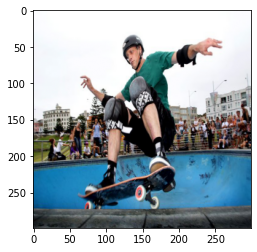

In [10]:
plt.imshow(img)

In [21]:
for i in range(10):
    print(' '.join(generate_caption(img, t=.5)[1:-1]))

a man in a blue shirt is doing a trick on a skateboard .
a young man riding a skateboard down the side of a ramp .
a man riding a skateboard up the side of a ramp .
a man riding a skateboard up the side of a ramp .
a man on a skateboard is performing a trick .
a man is jumping over a skateboard on a skateboard .
a man on a skateboard doing a trick in a skate park .
a man doing a trick on a skateboard at a skate park
a man flying through the air while riding a skateboard .
a man on a skateboard in the air on a skateboard .


--2022-02-13 16:07:19--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 162.159.135.42
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2022-02-13 16:07:19--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K  --.-KB/s    in 0.007s  

2022-02-13 16:07:19 (15.4 MB/s) - ‘img.jpg’ saved [106870/106870]



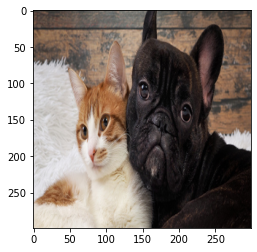

a close up of a cat laying on a carpet
a black and white cat is sitting down on a couch
a black and white cat is sitting on a red and yellow rug .
a small kitten is laying down in a mirror .
a small black and white cat stands next to a red and white cat .
a black and white cat standing on a couch
a cat is laying down on a couch
a small black and white cat laying on a rug .
a cat sitting on a couch next to a remote
a cat that is laying down on a bed .


In [22]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = resize(img, (299, 299))

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=.5)[1:-1]))

# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

--2022-02-13 16:08:02--  https://res.cloudinary.com/grand-canyon-university/image/fetch/w_724,h_483,c_fill,g_faces/https%3A%2F%2Fwww.gcu.edu%2Fsites%2Fdefault%2Ffiles%2F2020-09%2Fprogramming.jpg
Resolving res.cloudinary.com (res.cloudinary.com)... 184.50.20.44, 2600:140e:6:7a3::523, 2600:140e:6:7bf::523
Connecting to res.cloudinary.com (res.cloudinary.com)|184.50.20.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104565 (102K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 102.11K  --.-KB/s    in 0.03s   

2022-02-13 16:08:02 (3.11 MB/s) - ‘img.jpg’ saved [104565/104565]



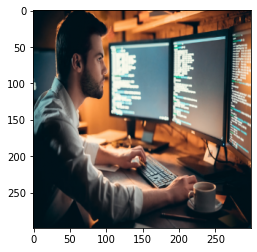

a person is working on a computer keyboard
a man is sitting at a table with a laptop .
a man is working on a laptop at a desk .
a man is using a computer mouse and keyboard .
a person that is sitting at a desk with a computer .
a person sitting in front of a computer monitor .
a man is sitting at a computer desk with a keyboard .
a person sitting at a desk with a computer mouse .
a person is sitting at a desk with a computer .
a man sitting at a table using a computer .


In [23]:
# apply your network on images you've found
!wget https://res.cloudinary.com/grand-canyon-university/image/fetch/w_724,h_483,c_fill,g_faces/https%3A%2F%2Fwww.gcu.edu%2Fsites%2Fdefault%2Ffiles%2F2020-09%2Fprogramming.jpg -O img.jpg

img = plt.imread('img.jpg')
img = resize(img, (299, 299))

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=0.5)[1:-1]))

--2022-02-13 16:08:24--  https://thefoodconnect.com/wp-content/uploads/2020/02/Chef-And-A-Cook.jpg
Resolving thefoodconnect.com (thefoodconnect.com)... 51.79.231.79, 2402:1f00:8001:124f::
Connecting to thefoodconnect.com (thefoodconnect.com)|51.79.231.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38558 (38K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  37.65K  --.-KB/s    in 0.05s   

2022-02-13 16:08:26 (820 KB/s) - ‘img.jpg’ saved [38558/38558]



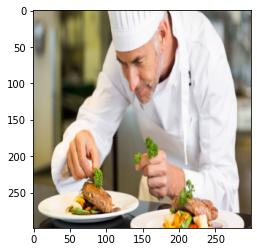

a man that is sitting down with a bowl of food .
a man standing in front of a white plate of food .
a man is holding two plates of food .
a man is sitting in a restaurant eating a sandwich .
a man in a white shirt and a apron are eating food .
a man in a white shirt and tie is eating something .
a man sitting at a table with a plate of food .
a man with glasses is holding a plate of food .
a man holding a plate of food in his hands .
a man is sitting at a table with a plate of food


In [24]:
!wget https://thefoodconnect.com/wp-content/uploads/2020/02/Chef-And-A-Cook.jpg -O img.jpg

img = plt.imread('img.jpg')
img = resize(img, (299, 299))

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=0.5)[1:-1]))

--2022-02-13 16:09:10--  https://d1jyxxz9imt9yb.cloudfront.net/medialib/1792/image/s768x1300/elephant-calf-mom-IFAW_slash_B._Hollweg.jpg
Resolving d1jyxxz9imt9yb.cloudfront.net (d1jyxxz9imt9yb.cloudfront.net)... 13.224.163.191, 13.224.163.211, 13.224.163.2, ...
Connecting to d1jyxxz9imt9yb.cloudfront.net (d1jyxxz9imt9yb.cloudfront.net)|13.224.163.191|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84584 (83K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  82.60K  --.-KB/s    in 0.05s   

2022-02-13 16:09:10 (1.79 MB/s) - ‘img.jpg’ saved [84584/84584]



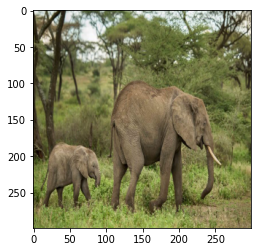

a large elephant standing next to a baby elephant .
an elephant standing in a grassy field near a tree .
a large elephant walking on a lush green field .
a baby elephant is standing in a field .
a group of elephants are standing in a grassy field .
a couple of elephants standing in the grass .
two elephants are walking through a field of grass .
an elephant standing in a grassy area with trees in the background .
an elephant is standing in the dirt and trees .
a baby elephant standing in a field of grass .


In [26]:
!wget https://d1jyxxz9imt9yb.cloudfront.net/medialib/1792/image/s768x1300/elephant-calf-mom-IFAW_slash_B._Hollweg.jpg -O img.jpg

img = plt.imread('img.jpg')
img = resize(img, (299, 299))

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=0.5)[1:-1]))

--2022-02-13 16:09:31--  https://i.pinimg.com/600x315/44/0a/40/440a40cc3c71b21b4a6229f4ca31a967.jpg
Resolving i.pinimg.com (i.pinimg.com)... 184.50.20.207, 2600:1417:8000:bb1::1931, 2600:1417:8000:ba7::1931, ...
Connecting to i.pinimg.com (i.pinimg.com)|184.50.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14423 (14K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  14.08K  --.-KB/s    in 0.003s  

2022-02-13 16:09:31 (4.86 MB/s) - ‘img.jpg’ saved [14423/14423]



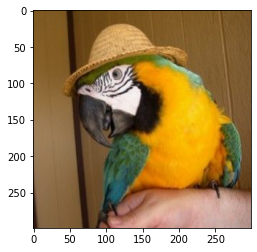

a parrot with a red parrot in its mouth
a colorful parrot is sitting on a branch .
a parrot with a blue beak sitting on a branch .
a parrot with its beak open on its head
a colorful parrot has a red hat on its neck .
a parrot in a blue shirt and a black parrot
a colorful parrot is standing on a branch
a parrot has a small beak on its head .
a parrot is holding a yellow and blue bird .
a parrot with a parrot in his beak .


In [27]:
!wget https://i.pinimg.com/600x315/44/0a/40/440a40cc3c71b21b4a6229f4ca31a967.jpg -O img.jpg

img = plt.imread('img.jpg')
img = resize(img, (299, 299))

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=0.5)[1:-1]))

# Вычисление BLEU и ROUGE

In [ ]:
def compute_metrics(model, dataloader, with_attention, max_len=60):
  references = []
  hypotheses = []
  model.eval()

  with torch.no_grad():
    for batch in tqdm(dataloader):
      image_data = batch['image_data'].to(device)
      references.extend(batch['raw_captions'])

      if not with_attention:
        batch_size = image_data.size(0)
        generated = torch.tensor([[SOS] for _ in range(batch_size)], device=device)
        for i_seq in range(max_len):
          logits = model(image_data, generated)  
          # logits = [batch size, current seq len, vocab size]
          tokens = logits[:, -1].argmax(dim=-1, keepdim=True)
          # tokens = [batch size, 1]
          generated = torch.hstack((generated, tokens))
      else:
        generated, _, _ = model(image_data, None, sample=greedy_sample, 
                                max_len=max_len)

      # generated = [batch size, seq len]
      for sequence in generated:
        hypothes = []
        for idx in sequence:
          if idx == EOS:
            break
          if idx not in [SOS, PAD, UNK]:
            hypothes.append(idx2token[idx.item()])
        hypotheses.append(hypothes)

  rouge = PyRouge()
  rouge_hypotheses = list(map(lambda hypothes: ' '.join(hypothes), hypotheses))
  rouge_references = []
  for img_references in references:
    new_img_references = []
    for reference in img_references:
      new_img_references.append(' '.join(reference))
    rouge_references.append(new_img_references)

  return {'bleu': corpus_bleu(references, hypotheses),
          'rouge-l': rouge.evaluate(rouge_hypotheses, rouge_references)['rouge-l']}

In [ ]:
metrics_loader = DataLoader(val_data, batch_size=64, shuffle=False, 
                            num_workers=2, collate_fn=train_collate_fn)
metrics = compute_metrics(network, metrics_loader, with_attention=False)
print(f"Validation BLEU: {metrics['bleu']}")
print(f"Validation ROUGE-L: {metrics['rouge-l']}")

# Бонус: Achtung

В качестве бонусного задания предлагается реализовать механизм attention в rnn-сети, которую мы писали в базовой части.

## Подготовка данных для сети с Attention

In [ ]:
# coco_dir = '../input/ms-coco-captioning'
coco_dir = '/content/MS_COCO'

In [ ]:
# Распаковать архивы с датасетом COCO
!unzip -q /content/gdrive/MyDrive/DLS_Project/annotations_trainval2014.zip -d $coco_dir
!unzip -q /content/gdrive/MyDrive/DLS_Project/train2014.zip -d $coco_dir
!unzip -q /content/gdrive/MyDrive/DLS_Project/val2014.zip -d $coco_dir

In [ ]:
!gdown --id 105wnRFAFCQHW4ZO8QQPFd_6NaHXogdIE
!unzip -q /content/train2014.zip -d $coco_dir
!rm /content/train2014.zip

!gdown --id 1eKYTIEXOH6o28z4tdQ-0YVUfmIJyLbNm
!unzip -q /content/val2014.zip -d $coco_dir
!rm /content/val2014.zip

!gdown --id 1F-AQgSKS-wnyLR4qt3ziarneAFefyiab
!unzip -q /content/annotations_trainval2014.zip -d $coco_dir
!rm /content/annotations_trainval2014.zip

In [ ]:
# Kaggle environment
!gdown --id 1-dgtsSxG88xu8mCbE9AHx6N3zfSUB-U_

Создадим и сохраним словарь, ключами которого являются относительные пути до изображений, а значениями - списки описаний.

In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

def extract_captions(captions_annotation, img_id):
  captions = list(filter(lambda caption: caption['image_id'] == img_id, 
                         captions_annotation))

  res = []
  for caption in captions:
    tokens = ' '.join(word_tokenize(caption['caption'].lower()))
    res.append(tokens)

  return res

In [ ]:
with open(os.path.join(coco_dir, 'annotations/captions_train2014.json')) as f:
    annotation = json.load(f)
extract_captions(annotation['annotations'], 57870)

In [ ]:
def group_captions(captions_files, img_dirs):
  res = dict()

  for captions_file, img_dir in zip(captions_files, img_dirs):
    with open(captions_file, 'r') as f:
      annotation = json.load(f)
      for img_info in tqdm(annotation['images']):
        captions = extract_captions(annotation['annotations'], img_info['id'])
        file_name = os.path.join(img_dir, img_info['file_name'])
        res[file_name] = captions

  with open(os.path.join(DATA_PATH, 'image_to_captions.json'), 'w') as f:
    json.dump(res, f)

captions_files = [os.path.join(coco_dir, 'annotations/captions_train2014.json'),
                  os.path.join(coco_dir, 'annotations/captions_val2014.json')]
group_captions(captions_files, ['train2014', 'val2014'])

Построим словарь и закодируем токены в текстах.

In [28]:
image_to_captions = json.load(open(os.path.join(DATA_PATH, 'image_to_captions.json')))
captions = list(image_to_captions.values())
captions[-2:]

[['a group of two women and one man sitting at a table .',
  'two women and a man eating lollipops at a dinner table .',
  'two women and a man sitting at a table .',
  'three people sit at a table holding lollipops',
  'two men and a woman sit at a table that is in front of a large bookshelf and the table has wine glasses and a bottle of wine on it .'],
 ['a man in glasses is holding a wine glass',
  'a man holds a glass in aroom with many other people',
  'a man holds a glass as others mill around behind him .',
  'a group of people standing around in a room .',
  'a man holding a glass speaking to someone']]

In [33]:
vocab = build_vocab(captions)
print(f'Количество токенов в словаре: {len(vocab)}')
vocab.most_common()[-10:]

Количество токенов в словаре: 30133


[('stroked', 1),
 ('skydiving', 1),
 ('wrangles', 1),
 ('taptops', 1),
 ('well-connected', 1),
 ('kites.are', 1),
 ('sandlot', 1),
 ('telegraphs', 1),
 ('tchen', 1),
 ('aroom', 1)]

In [34]:
vocab = filter_vocab(vocab, 2)
print(f'Количество токенов в словаре после фильтрации: {len(vocab)}')

Количество токенов в словаре после фильтрации: 17135


In [35]:
token2idx = build_token2idx(vocab)
list(token2idx.items())[:10]

[('<pad>', 0),
 ('<unk>', 1),
 ('<sos>', 2),
 ('<eos>', 3),
 ('a', 4),
 ('restaurant', 5),
 ('has', 6),
 ('modern', 7),
 ('wooden', 8),
 ('tables', 9)]

In [36]:
idx2token = {idx: token for token, idx in token2idx.items()}
list(idx2token.items())[:10]

[(0, '<pad>'),
 (1, '<unk>'),
 (2, '<sos>'),
 (3, '<eos>'),
 (4, 'a'),
 (5, 'restaurant'),
 (6, 'has'),
 (7, 'modern'),
 (8, 'wooden'),
 (9, 'tables')]

In [37]:
encoded = compute_encoded(captions, token2idx)
encoded[:2]

[[[2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 3],
  [2, 4, 13, 5, 14, 15, 16, 17, 18, 11, 12, 3],
  [2, 4, 13, 14, 15, 4, 19, 20, 21, 22, 23, 24, 15, 8, 11, 3],
  [2, 4, 13, 14, 15, 4, 25, 26, 27, 28, 29, 30, 1, 3],
  [2, 4, 14, 31, 32, 15, 8, 11, 15, 33, 34, 12, 3]],
 [[2, 4, 35, 36, 37, 27, 4, 38, 39, 27, 40, 12, 3],
  [2, 4, 41, 31, 36, 10, 42, 43, 44, 45, 12, 3],
  [2, 4, 46, 47, 48, 49, 22, 50, 51, 12, 3],
  [2, 4, 52, 53, 22, 4, 54, 55, 4, 56, 27, 4, 57, 3],
  [2, 52, 53, 22, 4, 58, 59, 48, 45, 12, 3]]]

In [38]:
captions = [[caption.split() for caption in img_captions] for img_captions in captions]
captions[:2]

[[['a',
   'restaurant',
   'has',
   'modern',
   'wooden',
   'tables',
   'and',
   'chairs',
   '.'],
  ['a',
   'long',
   'restaurant',
   'table',
   'with',
   'rattan',
   'rounded',
   'back',
   'chairs',
   '.'],
  ['a',
   'long',
   'table',
   'with',
   'a',
   'plant',
   'on',
   'top',
   'of',
   'it',
   'surrounded',
   'with',
   'wooden',
   'chairs'],
  ['a',
   'long',
   'table',
   'with',
   'a',
   'flower',
   'arrangement',
   'in',
   'the',
   'middle',
   'for',
   'meetings'],
  ['a',
   'table',
   'is',
   'adorned',
   'with',
   'wooden',
   'chairs',
   'with',
   'blue',
   'accents',
   '.']],
 [['a',
   'man',
   'preparing',
   'desserts',
   'in',
   'a',
   'kitchen',
   'covered',
   'in',
   'frosting',
   '.'],
  ['a',
   'chef',
   'is',
   'preparing',
   'and',
   'decorating',
   'many',
   'small',
   'pastries',
   '.'],
  ['a', 'baker', 'prepares', 'various', 'types', 'of', 'baked', 'goods', '.'],
  ['a',
   'close',
   'up',
   

(6, 57)

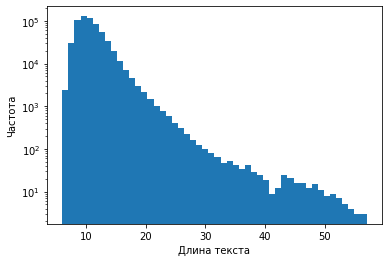

In [39]:
len_dist = [len(caption) for img_captions in captions for caption in img_captions]
plt.hist(len_dist, bins=50, log=True)
plt.xlabel('Длина текста')
plt.ylabel('Частота')
min(len_dist), max(len_dist)

Text(0, 0.5, 'Частота')

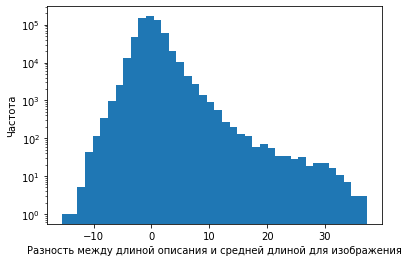

In [40]:
len_deviation_dist = []
for img_captions in captions:
  for caption in img_captions:
    len_deviation_dist.append(len(caption) - np.mean(list(map(len, img_captions))))
plt.hist(len_deviation_dist, bins=40, log=True)
plt.xlabel('Разность между длиной описания и средней длиной для изображения')
plt.ylabel('Частота')

Реализуем классы для датасета и загрузчика данных.

In [ ]:
class ImagesDataset(Dataset):
  def __init__(self, root_dir, image_files, encoded_captions, raw_captions, resize):
    super().__init__()
    self.root_dir = root_dir
    self.image_files = list(image_files)
    self.encoded_captions = list(encoded_captions)
    self.raw_captions = list(raw_captions)

    if resize:
      self.prepare_image = transforms.Compose([transforms.Resize((299, 299)), 
                                               transforms.ToTensor()])
    else:
      self.prepare_image = transforms.ToTensor()

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
    image_file = self.image_files[idx]
    image = Image.open(os.path.join(self.root_dir, image_file))
    if image.mode == 'L':
      image = image.convert('RGB')
    image = self.prepare_image(image)

    return {'image': image, 'encoded_captions': self.encoded_captions[idx], 
            'raw_captions': self.raw_captions[idx]}

In [ ]:
# Kaggle
image_files = list(image_to_captions.keys())
for i_file, image_file in enumerate(image_files):
    if image_file.startswith('train2014'):
        image_files[i_file] = 'train2014/' + image_file
    elif image_file.startswith('val2014'):
        image_files[i_file] = 'val2014/' + image_file

In [ ]:
img_dataset = ImagesDataset(coco_dir, image_to_captions.keys(), encoded, 
                            captions, resize=False)
img_dataset[0]

{'encoded_captions': [[2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 3],
  [2, 4, 13, 5, 14, 15, 16, 17, 18, 11, 12, 3],
  [2, 4, 13, 14, 15, 4, 19, 20, 21, 22, 23, 24, 15, 8, 11, 3],
  [2, 4, 13, 14, 15, 4, 25, 26, 27, 28, 29, 30, 1, 3],
  [2, 4, 14, 31, 32, 15, 8, 11, 15, 33, 34, 12, 3]],
 'image': tensor([[[0.3373, 0.3098, 0.3098,  ..., 0.5804, 0.7961, 0.8471],
          [0.3451, 0.2745, 0.3686,  ..., 0.5451, 0.7490, 0.9020],
          [0.3451, 0.3412, 0.3294,  ..., 0.6667, 0.8196, 0.8706],
          ...,
          [0.2078, 0.2000, 0.1765,  ..., 0.6078, 0.6039, 0.6000],
          [0.3176, 0.2941, 0.2902,  ..., 0.5922, 0.5961, 0.5961],
          [0.2235, 0.1961, 0.2314,  ..., 0.5882, 0.6000, 0.6078]],
 
         [[0.1804, 0.1843, 0.2039,  ..., 0.4863, 0.6392, 0.6039],
          [0.1569, 0.1216, 0.2471,  ..., 0.4275, 0.5686, 0.6353],
          [0.1176, 0.1686, 0.2039,  ..., 0.5412, 0.6314, 0.5961],
          ...,
          [0.0784, 0.0824, 0.0549,  ..., 0.6353, 0.6275, 0.6235],
          [0.2118, 

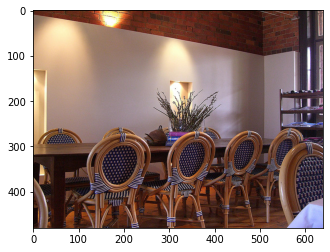

In [ ]:
plt.imshow(img_dataset[0]['image'].permute(1, 2, 0))

In [47]:
def img_train_collate_fn(batch, stack_images):
  images = []
  i_caption = [np.random.choice(len(xy['encoded_captions'])) for xy in batch]
  max_len = max(len(xy['encoded_captions'][i]) for xy, i in zip(batch, i_caption))
  padded_captions = torch.full((len(batch), max_len), PAD)
  raw_captions = []

  for i_xy, xy in enumerate(batch):
    caption = xy['encoded_captions'][i_caption[i_xy]]
    padded_captions[i_xy][:len(caption)] = torch.tensor(caption)
    images.append(xy['image'])
    raw_captions.append(xy['raw_captions'])

  return {'image_data': stack_images(images), 
          'encoded_captions': padded_captions,
          'raw_captions': raw_captions}

def img_eval_collate_fn(batch, stack_images):
  images = []
  n_rows = sum(len(xy['encoded_captions']) for xy in batch)
  max_len = max(len(caption) for xy in batch for caption in xy['encoded_captions'])
  padded_captions = torch.full((n_rows, max_len), PAD)

  i_row = 0
  for xy in batch:
    for caption in xy['encoded_captions']:
      padded_captions[i_row][:len(caption)] = torch.tensor(caption)
      i_row += 1
      images.append(xy['image'])

  return {'image_data': stack_images(images), 
          'encoded_captions': padded_captions}

train_collate_fn_for_classification = functools.partial(img_train_collate_fn, 
                                                        stack_images=torch.stack)
eval_collate_fn_for_classification = functools.partial(img_eval_collate_fn, 
                                                       stack_images=torch.stack)

detection_model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, 
                                                                         pretrained_backbone=False).eval()
detection_transform = detection_model.transform
train_collate_fn_for_detection = functools.partial(img_train_collate_fn, 
                                                   stack_images=lambda x: detection_transform(x)[0].tensors)
eval_collate_fn_for_detection = functools.partial(img_eval_collate_fn, 
                                                  stack_images=lambda x: detection_transform(x)[0].tensors)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [ ]:
train_len = int(len(img_dataset) * 0.8)
train_data, val_data = torch.utils.data.random_split(img_dataset, 
                                                     (train_len, len(img_dataset) - train_len),
                                                     generator=torch.Generator().manual_seed(42))
print(f'Размер обучающей выборки: {len(train_data)}')
print(f'Размер валидационной выборки: {len(val_data)}')

Размер обучающей выборки: 98629
Размер валидационной выборки: 24658


In [ ]:
img_train_loader = DataLoader(train_data, batch_size=16, shuffle=True, 
                              num_workers=2, collate_fn=train_collate_fn_for_detection)
img_val_loader = DataLoader(val_data, batch_size=3, shuffle=False, 
                            num_workers=2, collate_fn=eval_collate_fn_for_detection)

In [ ]:
batch = next(iter(img_train_loader))
batch['image_data'].size(), batch['encoded_captions'].size(), len(batch['raw_captions'])

(torch.Size([16, 3, 448, 640]), torch.Size([16, 17]), 16)

In [ ]:
batch['raw_captions']

## Decoder with Attention

In [41]:
class FasterRCNNEncoder(nn.Module):
  def __init__(self, backbone):
    super().__init__()
    self.backbone = backbone

  def forward(self, input):
    x = self.backbone(input)
    enc_hid_size = x['pool'].size(1)
    averaged_x = F.adaptive_avg_pool2d(x['pool'], (1, 1)).reshape(-1, enc_hid_size)
    return list(x.values()), averaged_x, None

In [42]:
class Decoder(nn.Module):
  def __init__(self, vocab_size, embedding_size, dec_hid_size, num_layers, 
               dropout, attention_layer, skip_connections, padding_idx):
    super().__init__()

    self.vocab_size = vocab_size
    self.embedding_size = embedding_size
    self.dec_hid_size = dec_hid_size
    self.num_layers = num_layers
    self.dropout_p = dropout
    self.skip_connections = skip_connections

    self.embeddings = nn.Embedding(vocab_size, embedding_size, 
                                   padding_idx=padding_idx)
    self.dropout = nn.Dropout(p=dropout)
    self.attention = attention_layer
    self.rnn = nn.LSTM(input_size=embedding_size + sum(attention_layer.enc_hid_sizes), 
                       hidden_size=dec_hid_size, num_layers=num_layers, 
                       batch_first=True, dropout=dropout)
    if skip_connections:
      self.out = nn.Linear(dec_hid_size + sum(attention_layer.enc_hid_sizes) + embedding_size, 
                           vocab_size)
    else:
      self.out = nn.Linear(dec_hid_size, vocab_size)

  def forward(self, input, hidden, cell, encoder_outputs):
    # input = [batch size]
    # hidden = [num layers, batch size, dec hid size]
    # cell = [num layers, batch size, dec hid size]
    # encoder_outputs = num_attentions, [batch size, enc vectors number, enc hid size]
    
    embedded = self.dropout(self.embeddings(input))
    # embedded = [batch size, embedding size]

    context_vectors, attentions = self.attention(hidden[-1], encoder_outputs)
    context_vectors = self.dropout(context_vectors)
    # context_vectors = [batch size, sum(enc hid sizes)]
    # attentions = num attentions, [batch size, enc vectors number]
    concatenated = torch.cat((embedded, context_vectors), dim=-1).unsqueeze(1)
    # concatenated = [batch size, 1, embedding size + sum(enc hid sizes)]

    decoder_outputs, (hidden, cell) = self.rnn(concatenated, (hidden, cell))
    # decoder_outputs = [batch size, 1, dec hid size]
    # hidden = [num layers, batch size, dec hid size]
    # cell = [num layers, batch size, dec hid size]

    if self.skip_connections:
      triple = torch.cat((concatenated, decoder_outputs), dim=-1).squeeze(1)
      # triple = [batch size, embedding size + sum(enc hid sizes) + dec hid size]
      logits = self.out(triple)
    else:
      decoder_outputs = decoder_outputs.squeeze(1)
      # decoder_outputs = [batch size, dec hid size]
      logits = self.out(decoder_outputs)

    # logits = [batch size, vocab size]
    
    return logits, hidden, cell, attentions

In [43]:
class Attention(nn.Module):
  '''
  Класс для совместимости с моделями с одним attention
  '''
  def __init__(self, enc_hid_size, dec_hid_size):
    super().__init__()

    self.enc_hid_sizes = [enc_hid_size]
    self.dec_hid_size = dec_hid_size

    self.attn = nn.Linear(enc_hid_size + dec_hid_size, dec_hid_size)
    self.v = nn.Linear(dec_hid_size, 1)

  def forward(self, hidden, encoder_outputs):
    # hidden = [batch size, dec hid size]
    # encoder_outputs = 1, [batch size, enc vectors number, enc hid size]

    encoder_outputs = encoder_outputs[0]
    # encoder_outputs = [batch size, enc vectors number, enc hid size]

    hidden = hidden.unsqueeze(1).repeat(1, encoder_outputs.size(1), 1)
    # hidden = [batch size, enc vectors number, dec hid size]
    concatenated = torch.cat((hidden, encoder_outputs), dim=-1)
    # concatenated = [batch size, enc vectors number, dec hid size + enc hid size]
    attention = torch.tanh(self.attn(concatenated))
    attention = F.softmax(self.v(attention), dim=1)
    # attention = [batch size, enc vectors number, 1]

    context_vectors = (attention * encoder_outputs).sum(dim=1)
    # context_vectors = [batch size, enc hid size]
    attention = attention.squeeze(-1)
    # attention = [batch size, enc vectors number]
    return context_vectors, [attention]

In [44]:
class MultipleAttention(nn.Module):
  def __init__(self, enc_hid_sizes, dec_hid_size):
    super().__init__()

    self.enc_hid_sizes = enc_hid_sizes
    self.dec_hid_size = dec_hid_size
    
    self.attn = nn.ModuleList([nn.Linear(enc_hid_size + dec_hid_size, dec_hid_size) for enc_hid_size in enc_hid_sizes])
    self.v = nn.ModuleList([nn.Linear(dec_hid_size, 1) for _ in range(len(enc_hid_sizes))])
        
  def forward(self, hidden, encoder_outputs):
    # hidden = [batch size, dec hid size]
    # encoder_outputs = num attentions, [batch size, enc vectors number, enc hid size]
    
    hidden = hidden.unsqueeze(1)
    # hidden = [batch size, 1, dec hid size]
    
    context_vectors = []
    attentions = []
    
    for encoder_output, attn, v in zip(encoder_outputs, self.attn, self.v):
      repeated_hidden = hidden.repeat(1, encoder_output.size(1), 1)
      # repeated_hidden = [batch size, enc vectors number, dec hid size]
      concatenated = torch.cat((repeated_hidden, encoder_output), dim=-1)
      # concatenated = [batch size, enc vectors number, dec hid size + enc hid size]
      attention = torch.tanh(attn(concatenated))
      attention = F.softmax(v(attention), dim=1)
      # attention = [batch size, enc vectors number, 1]

      context_vector = (attention * encoder_output).sum(dim=1)
      # context_vector = [batch size, enc hid size]
      attention = attention.squeeze(-1)
      # attention = [batch size, enc vectors number]
        
      context_vectors.append(context_vector)
      attentions.append(attention)
    
    context_vectors = torch.hstack(context_vectors)
    # context_vectors = [batch size, sum(enc hid sizes)]
    # attentions = num attentions, [batch size, enc vectors number]
    
    return context_vectors, attentions

In [45]:
class CaptionNetWithAttention(nn.Module):
  def __init__(self, encoder, decoder, init_hidden_cell, out_enc_hid_size, 
               dropout):
    super().__init__()

    self.init_hidden_cell = init_hidden_cell
    self.out_enc_hid_size = out_enc_hid_size

    self.encoder = encoder
    if init_hidden_cell:
      self.hidden_projection = nn.Linear(out_enc_hid_size, 
                                         decoder.num_layers * decoder.dec_hid_size)
      self.cell_projection = nn.Linear(out_enc_hid_size, 
                                       decoder.num_layers * decoder.dec_hid_size)
    self.dropout = nn.Dropout(p=dropout)
    self.decoder = decoder
      
  def forward(self, images, captions_ix, sample=None, max_len=100):
    # images = [batch size, 3, height, width]
    # captions_ix = [batch size, seq len]

    encoder_outputs, img_codes, _ = self.encoder(images)
    if not isinstance(encoder_outputs, list):
      encoder_outputs = [encoder_outputs]
    # encoder_outputs = num attentions, [batch size, enc hid size, n_rows, n_cols]
    # img_codes = [batch size, out enc hid size]
    
    hidden, cell = self.compute_initial_hidden_cell(img_codes)
    # hidden = [num layers, batch size, dec hid size]
    # cell = [num layers, batch size, dec hid size]

    batch_size = images.size(0)

    feature_maps_size = []
    for i_output, encoder_output in enumerate(encoder_outputs):
      feature_maps_size.append(encoder_output.size()[-2:])
      encoder_output = encoder_output.reshape(batch_size, self.decoder.attention.enc_hid_sizes[i_output], -1)
      encoder_outputs[i_output] = encoder_output.permute(0, 2, 1)
    # encoder_outputs = num attentions, [batch size, enc vectors number, enc hid size]
    # feature_maps_size = num attentions

    if captions_ix is not None:
      return self.train_prediction(captions_ix, hidden, cell, encoder_outputs)
    else:
      decoded, total_attentions = self.inference_prediction(sample, hidden, cell, 
                                                            encoder_outputs, 
                                                            max_len)
      return decoded, total_attentions, feature_maps_size     

  def train(self, mode=True):
    self.training = mode

    if self.init_hidden_cell:
      self.hidden_projection.train(mode)
      self.cell_projection.train(mode)
    self.decoder.train(mode)
    
    return self

  def compute_initial_hidden_cell(self, img_codes):
    # img_codes = [batch size, out enc hid size]

    if self.init_hidden_cell:
      hidden = F.relu(self.hidden_projection(img_codes))
      # hidden = [batch size, num layers * dec hid size]
      hidden = hidden.reshape(-1, self.decoder.num_layers, self.decoder.dec_hid_size)
      hidden = hidden.permute(1, 0, 2).contiguous()
      hidden = self.dropout(hidden)
      # hidden = [num layers, batch size, dec hid size]

      cell = F.relu(self.cell_projection(img_codes))
      # cell = [batch size, num layers * dec hid size]
      cell = cell.reshape(-1, self.decoder.num_layers, self.decoder.dec_hid_size)
      cell = cell.permute(1, 0, 2).contiguous()
      cell = self.dropout(cell)
      # cell = [num layers, batch size, dec hid size]
    else:
      batch_size = img_codes.size(0)
      device = 'cuda' if img_codes.is_cuda else 'cpu'

      hidden = torch.zeros(self.decoder.num_layers, batch_size, 
                           self.decoder.dec_hid_size, device=device)
      cell = torch.zeros(self.decoder.num_layers, batch_size, 
                         self.decoder.dec_hid_size, device=device)
    return hidden, cell

  def train_prediction(self, captions_ix, hidden, cell, encoder_outputs):
    # captions_ix = [batch size, seq len]
    # hidden = [num layers, batch size, dec hid size]
    # cell = [num layers, batch size, dec hid size]
    # encoder_outputs = num attentions, [batch size, enc vectors number, enc hid size]

    batch_size = captions_ix.size(0)
    seq_len = captions_ix.size(1)
    device = 'cuda' if captions_ix.is_cuda else 'cpu'

    decoded = torch.zeros(batch_size, seq_len, self.decoder.vocab_size, 
                          device=device)
    for i_seq in range(seq_len):
      logits, hidden, cell, attentions = self.decoder(captions_ix[:, i_seq], 
                                                      hidden, cell, 
                                                      encoder_outputs)
      # logits = [batch size, vocab size]
      decoded[:, i_seq, :] = logits
    return decoded

  def inference_prediction(self, sample, hidden, cell, encoder_outputs, max_len):
    # hidden = [num layers, batch size, dec hid size]
    # cell = [num layers, batch size, dec hid size]
    # encoder_outputs = num attentions, [batch size, enc vectors number, enc hid size]

    batch_size = encoder_outputs[0].size(0)
    device = 'cuda' if encoder_outputs[0].is_cuda else 'cpu'

    input = torch.full((batch_size,), SOS, device=device)
    decoded = [input]
    continue_mask = torch.full((batch_size,), True, device=device)
    total_attentions = [[] for _ in range(len(self.decoder.attention.enc_hid_sizes))]
  
    while len(decoded) <= max_len and continue_mask.sum() != 0:
      logits, hidden, cell, attentions = self.decoder(input, hidden, cell, 
                                                      encoder_outputs)
      # logits = [batch size, vocab size]
      # attentions = num attentions, [batch size, enc vectors number]

      input = sample(logits)
      # input = [batch size]
      decoded.append(input)

      continue_mask = continue_mask & (input != EOS)
      # continue_mask = [batch size]
      for total_attention, attention in zip(total_attentions, attentions):
        total_attention.append(attention)

    decoded = torch.stack(decoded, dim=1)
    # decoded = [batch size, seq len]
    for i, total_attention in enumerate(total_attentions):
      total_attentions[i] = torch.stack(total_attention).permute(1, 0, 2)
    # total_attentions = num attentions, [batch size, seq len, enc vectors number]

    return decoded, total_attentions

In [ ]:
network = CaptionNetWithAttention(encoder=FasterRCNNEncoder(detection_model.backbone).eval(), 
                                  decoder=Decoder(vocab_size=len(idx2token), 
                                                  embedding_size=256, 
                                                  dec_hid_size=1024, 
                                                  num_layers=2, dropout=0.5, 
                                                  attention_layer=MultipleAttention([256 for _ in range(3)], 1024),
                                                  skip_connections=True,
                                                  padding_idx=PAD), 
                                  init_hidden_cell=True,
                                  out_enc_hid_size=256,
                                  dropout=0.5).to(device)

In [ ]:
!nvidia-smi

In [ ]:
batch = next(iter(img_train_loader))
with torch.no_grad():
  output = network(batch['image_data'].to(device), batch['encoded_captions'].to(device))
  print(output.size())

## Обучение сети

In [ ]:
for param in network.encoder.parameters():
  param.requires_grad = False

In [ ]:
network

In [ ]:
optimizer = Adam(chain(network.decoder.parameters(),
                       network.hidden_projection.parameters(),
                       network.cell_projection.parameters()),
                 lr=0.0001)

In [ ]:
%%time
loss = compute_loss(network, batch['image_data'].to(device), 
                    batch['encoded_captions'].to(device))
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [ ]:
count_parameters_number(network)

Количество обучаемых параметров: 61,289,974


Начать обучение сети

In [ ]:
train_folder = os.path.join(DATA_PATH, 'CaptionNetWithAttention_FasterRCNN_Dropout')
if not os.path.exists(train_folder):
  os.mkdir(train_folder)
  save_dict(idx2token, os.path.join(train_folder, 'idx2token.json'))

Продолжить обучение

In [ ]:
# Kaggle
!gdown --id 1LdhMuJeqjPQDZ015wNA3XuWuqvmPbsqK
!unzip CaptionNetWithAttention_Resume.zip -d $DATA_PATH

Downloading...
From: https://drive.google.com/uc?id=1LdhMuJeqjPQDZ015wNA3XuWuqvmPbsqK
To: /content/CaptionNetWithAttention_Resume.zip
100% 935M/935M [00:08<00:00, 107MB/s]
Archive:  CaptionNetWithAttention_Resume.zip
  inflating: /content/CaptionNetWithAttention_FasterRCNN_Dropout/loss.png  
  inflating: /content/CaptionNetWithAttention_FasterRCNN_Dropout/history.json  
  inflating: /content/CaptionNetWithAttention_FasterRCNN_Dropout/idx2token.json  
  inflating: /content/CaptionNetWithAttention_FasterRCNN_Dropout/best_model.pt  
  inflating: /content/CaptionNetWithAttention_FasterRCNN_Dropout/checkpoint.pt  


In [ ]:
train_folder = os.path.join(DATA_PATH, 'CaptionNetWithAttention_FasterRCNN_Dropout')
network = CaptionNetWithAttention(encoder=FasterRCNNEncoder(detection_model.backbone).eval(), 
                                  decoder=Decoder(vocab_size=len(idx2token), 
                                                  embedding_size=256, 
                                                  dec_hid_size=1024, 
                                                  num_layers=2, dropout=0.5, 
                                                  attention_layer=MultipleAttention([256, 256, 256], 1024),
                                                  skip_connections=True, 
                                                  padding_idx=PAD), 
                                  init_hidden_cell=True,
                                  out_enc_hid_size=256,
                                  dropout=0.5).to(device)
for param in network.encoder.parameters():
  param.requires_grad = False
optimizer_params = {'params': chain(network.decoder.parameters(),
                                    network.hidden_projection.parameters(),
                                    network.cell_projection.parameters()),
                    'lr': 0.0001}
epoch, network, optimizer, _ = load_checkpoint(train_folder, 'checkpoint.pt', 
                                               network, Adam, optimizer_params)
history = load_dict(os.path.join(train_folder, 'history.json'))

In [ ]:
train(network, optimizer, img_train_loader, img_val_loader, 25, train_folder,
      scheduler=None, eval_time=2, history=history)

Загрузить сохранённую модель

In [61]:
folder_to_load = os.path.join(DATA_PATH, 'CaptionNetWithAttention_FasterRCNN_Dropout')

idx2token = load_dict(os.path.join(folder_to_load, 'idx2token.json'))
idx2token = dict(map(lambda item: (int(item[0]), item[1]), idx2token.items()))

network = CaptionNetWithAttention(encoder=FasterRCNNEncoder(detection_model.backbone).eval(), 
                                  decoder=Decoder(vocab_size=len(idx2token), 
                                                  embedding_size=256, 
                                                  dec_hid_size=1024, 
                                                  num_layers=2, dropout=0.5, 
                                                  attention_layer=MultipleAttention([256, 256, 256], 1024),
                                                  skip_connections=True, 
                                                  padding_idx=PAD), 
                                  init_hidden_cell=True,
                                  out_enc_hid_size=256,
                                  dropout=0.5).to(device)
network.load_state_dict(torch.load(os.path.join(folder_to_load, 'best_model.pt'), map_location=device))
network.to(device)

CaptionNetWithAttention(
  (encoder): FasterRCNNEncoder(
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (0): ConvNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(16, eps=1e-05)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): FrozenBatchNorm2d(16, eps=1e-05)
              (2): ReLU(inplace=True)
            )
            (1): ConvNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): FrozenBatchNorm2d(16, eps=1e-05)
            )
          )
        )
        (2): InvertedResidual(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(16, 64, kernel_size

In [ ]:
img_metrics_loader = DataLoader(val_data, batch_size=16, shuffle=False, 
                                num_workers=2, collate_fn=train_collate_fn_for_detection)
metrics = compute_metrics(network, img_metrics_loader, with_attention=True)
print(f"Validation BLEU: {metrics['bleu']}")
print(f"Validation ROUGE-L: {metrics['rouge-l']}")

  0%|          | 0/1542 [00:00<?, ?it/s]

Validation BLEU: 0.2570460755365665
Validation ROUGE-L: {'r': 0.3692252007050569, 'p': 0.3845913261832747, 'f': 0.3767516485360349}


## Demo

In [50]:
def generate_caption_with_attention(image, t=1, sample=True, max_len=100):
  network.eval()
  with torch.no_grad():
    if sample:
      generated, attentions, feature_maps_size = network(image, None, 
                                                         sample=functools.partial(random_sample, t=t), 
                                                         max_len=max_len)
    else:
      generated, attentions, feature_maps_size = network(image, None, 
                                                         sample=greedy_sample, 
                                                         max_len=max_len)

    # generated = [1, seq len]
    # attentions = num attentions, [batch size, seq len - 1, enc vectors number]
    # feature_maps_size = [num attentions]

  generated = [idx2token[idx.item()] for idx in generated[0]]

  return generated, attentions, feature_maps_size

In [ ]:
# !wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
# !wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
# !wget https://d1jyxxz9imt9yb.cloudfront.net/medialib/1792/image/s768x1300/elephant-calf-mom-IFAW_slash_B._Hollweg.jpg -O img.jpg
# !wget https://res.cloudinary.com/grand-canyon-university/image/fetch/w_724,h_483,c_fill,g_faces/https%3A%2F%2Fwww.gcu.edu%2Fsites%2Fdefault%2Ffiles%2F2020-09%2Fprogramming.jpg -O img.jpg
# !wget https://i.pinimg.com/600x315/44/0a/40/440a40cc3c71b21b4a6229f4ca31a967.jpg -O img.jpg
!wget https://thefoodconnect.com/wp-content/uploads/2020/02/Chef-And-A-Cook.jpg -O img.jpg

--2022-02-08 18:20:00--  https://thefoodconnect.com/wp-content/uploads/2020/02/Chef-And-A-Cook.jpg
Resolving thefoodconnect.com (thefoodconnect.com)... 51.79.231.79, 2402:1f00:8001:124f::
Connecting to thefoodconnect.com (thefoodconnect.com)|51.79.231.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38558 (38K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  37.65K   168KB/s    in 0.2s    

2022-02-08 18:20:01 (168 KB/s) - ‘img.jpg’ saved [38558/38558]



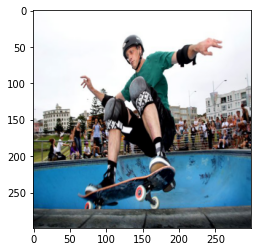

a man jumping on a skateboard in the middle of a ramp .
a man jumping into the air while riding a skateboard .
a man jumping a skateboard up a ramp .
a man is riding a skateboard on a skateboard .
a man jumping on a skateboard in the middle of a ramp .
a man is surfing on a skateboard in the air .
a man on a skateboard jumping over a ramp .
a man jumping up on a skateboard on a skateboard .
a skateboarder jumping a trick on a ramp .
a man on a skateboard in the air .


In [ ]:
# Модель с backbone от классификатора
img = plt.imread('img.jpg')

img_to_show = resize(img, (299, 299)).astype(np.float32)
img = torch.from_numpy(img_to_show).permute(2, 0, 1).unsqueeze(0)

plt.imshow(img_to_show)
plt.show()

for i in range(10):
    print(' '.join(generate_caption_with_attention(img.to(device), t=.5)[0][1:-1]))

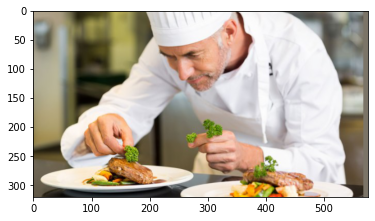

a man sitting at a table with a plate of food .
the man is eating a sandwich and is on the plate .
a man with glasses is eating a plate of food
a man eating pizza while sitting at a table .
a man with a plate of food on a table
a man is eating a sandwich and salad in a paper plate .
a man with a plate of food on a table
a man is eating a sandwich while sitting on a plate
a man holding a plate with a sandwich in it .
a man that is holding a plate of food .


In [ ]:
# Модель с backbone от детектора
img = plt.imread('img.jpg')

img = img.astype(np.float32) / 255.0
img = torch.from_numpy(img).permute(2, 0, 1)
img = detection_transform([img])[0].tensors

img_to_show = torch.clip(img[0].permute(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]),
                         min=0, max=1)
plt.imshow(img_to_show)
plt.show()

for i in range(10):
    print(' '.join(generate_caption_with_attention(img.to(device), t=.5)[0][1:-1]))

## Визуализация attention

In [51]:
def plot_attention(img, input_img, t, i_attention):
  generated, attentions, attention_sizes = generate_caption_with_attention(input_img, 
                                                                           t=t)
  # generated = [seq len]
  # attentions = num attentions, [1, seq len - 1, enc vectors number]
  # attn_sizes = [num attentions]
  
  generated = generated[1:]
  attention_sizes = attention_sizes[i_attention]

  attentions = attentions[i_attention].cpu().detach().numpy()[0]
  attentions = attentions.reshape(-1, *attention_sizes)
  # attentions = [seq len - 1, attn n rows, attn n cols]

  img_width = img.shape[1]
  img_height = img.shape[0]
  cell_width = img_width // attention_sizes[1]
  cell_height = img_height // attention_sizes[0]
  x_repeats = [cell_width for _ in range(attention_sizes[1])]
  y_repeats = [cell_height for _ in range(attention_sizes[0])]
  for i in range(1, img_width % attention_sizes[1] + 1):
    x_repeats[-i] += 1
  for i in range(1, img_height % attention_sizes[0] + 1):
    y_repeats[-i] += 1
  
  fig, axes = plt.subplots(3, np.ceil(len(generated) / 3).astype(int), 
                           figsize=(20, 11))
  axes = axes.reshape(-1)

  for ax, token, attention in zip(axes, generated, attentions): 
    attention = attention.repeat(y_repeats, axis=0).repeat(x_repeats, axis=1)
    attention = attention[:, :, None]
    attention = (attention - attention.min()) / (attention.max() - attention.min())

    attn_img = np.concatenate((img, attention), axis=2)
    
    ax.imshow(attn_img)
    ax.set_title(token)

In [55]:
# !wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
# !wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
!wget https://d1jyxxz9imt9yb.cloudfront.net/medialib/1792/image/s768x1300/elephant-calf-mom-IFAW_slash_B._Hollweg.jpg -O img.jpg
# !wget https://res.cloudinary.com/grand-canyon-university/image/fetch/w_724,h_483,c_fill,g_faces/https%3A%2F%2Fwww.gcu.edu%2Fsites%2Fdefault%2Ffiles%2F2020-09%2Fprogramming.jpg -O img.jpg
# !wget https://i.pinimg.com/600x315/44/0a/40/440a40cc3c71b21b4a6229f4ca31a967.jpg -O img.jpg
# !wget https://thefoodconnect.com/wp-content/uploads/2020/02/Chef-And-A-Cook.jpg -O img.jpg

--2022-02-13 16:31:04--  https://d1jyxxz9imt9yb.cloudfront.net/medialib/1792/image/s768x1300/elephant-calf-mom-IFAW_slash_B._Hollweg.jpg
Resolving d1jyxxz9imt9yb.cloudfront.net (d1jyxxz9imt9yb.cloudfront.net)... 13.224.163.191, 13.224.163.211, 13.224.163.113, ...
Connecting to d1jyxxz9imt9yb.cloudfront.net (d1jyxxz9imt9yb.cloudfront.net)|13.224.163.191|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84584 (83K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  82.60K  --.-KB/s    in 0.02s   

2022-02-13 16:31:04 (4.70 MB/s) - ‘img.jpg’ saved [84584/84584]



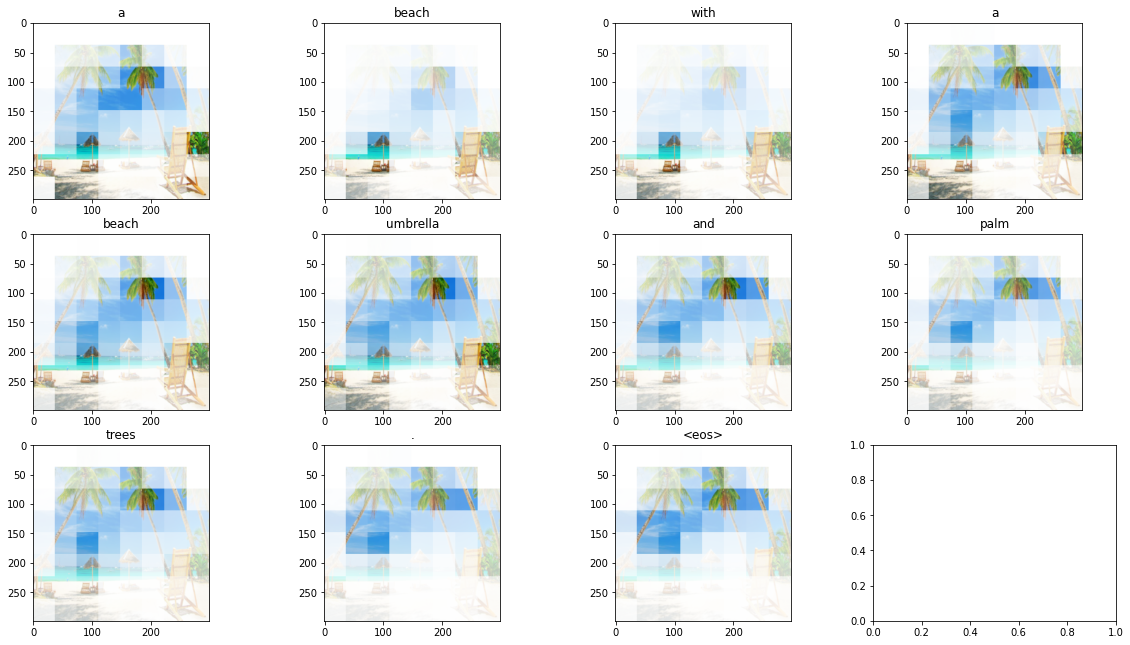

In [ ]:
# Визуализация attention для модели с backbone от классификатора
img = plt.imread('img.jpg')

img_to_show = resize(img, (299, 299)).astype(np.float32)
img = torch.from_numpy(img_to_show).permute(2, 0, 1).unsqueeze(0)
plot_attention(img_to_show, img.to(device), t=0.0000005, i_attention=0)

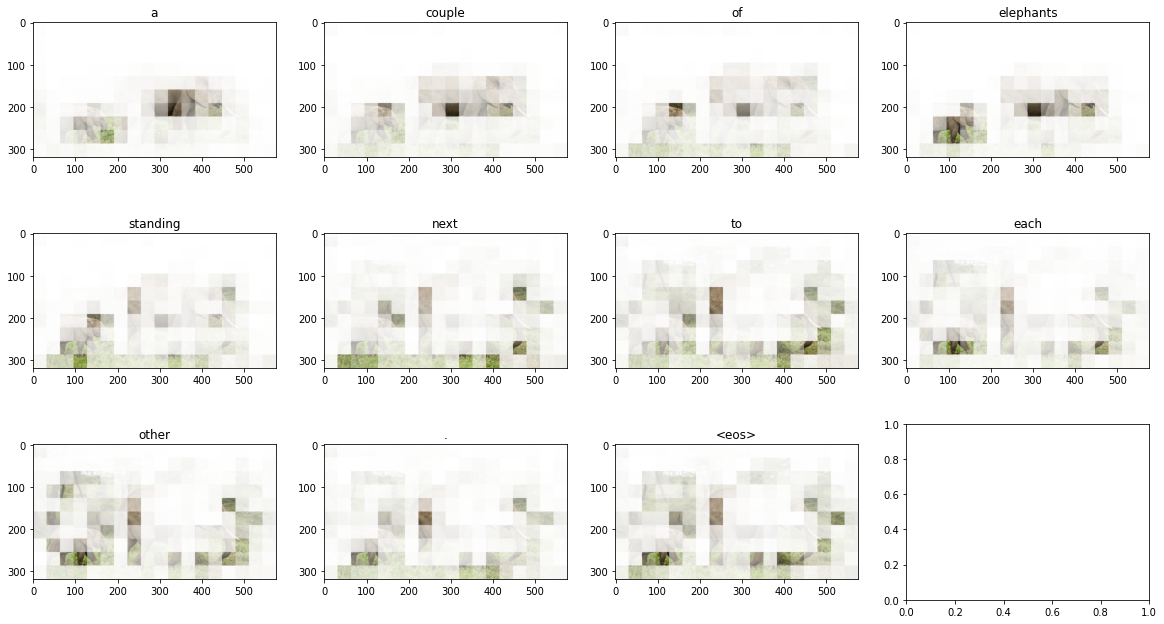

In [62]:
# Визуализация attention для модели с backbone от детектора
img = plt.imread('img.jpg')

img = img.astype(np.float32) / 255.0
img = torch.from_numpy(img).permute(2, 0, 1)
img = detection_transform([img])[0].tensors
img_to_show = torch.clip(img[0].permute(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]),
                         min=0, max=1)
plot_attention(img_to_show, img.to(device), t=0.0000005, i_attention=0)

# Результаты

Ниже представлена таблица, содержащая значения лосса, BLEU и ROUGE, вычисленные для различных модификаций сети без attention, обученных в течение 15 эпох. В ходе экспериментов были обучены и протестированы модели, отличающиеся количеством слоёв в RNN-сети, размерностью вектора скрытого состояния и размерностью эмбеддингов для токенов. Также была рассмотрена модель с гиперболическим тангенсом в качестве функции активации для полносвязных слоёв, переводящих эмбеддинги изображения в начальные состояния cell и hidden, и модель, обученная с постепенным уменьшением learning rate. 

| Модель | Train loss | Наименьший validation loss | Validation BLEU | Validation ROUGE-L |
|--|--|--|--|--|
| LSTM без Attention, embedding_size=256, hidden_size=512, <br/> num_layers=2, dropout=0.5, lr=0.00005 | 2.5548489767799456 | 2.5760696317853484 | 0.23587870818550215 | 0.3724918588894703 |
| LSTM без Attention, embedding_size=256, hidden_size=512, <br/> num_layers=4, dropout=0.5, lr=0.00005 | 2.608944892769923 | 2.62380133373355 | 0.23891144778107115 | **0.37630205468889655** |
| LSTM без Attention, embedding_size=256, hidden_size=512, <br/> num_layers=1, dropout=0.5, lr=0.00005 | 2.556955342591146 | 2.5690800523463664 | 0.2346480645789697 | 0.37160700468129165 |
| LSTM без Attention, embedding_size=256, hidden_size=512, <br/> num_layers=2, dropout=0.5, lr=0.001, StepLR(10, 0.1) | 2.3017910330749753 | **2.406245773083884** | 0.22198117756809292 | 0.360868050284715 |
| LSTM без Attention, embedding_size=256, hidden_size=1024, <br/> num_layers=2, dropout=0.5, lr=0.00005 | 2.368683464838617 | 2.4612547944349714 | **0.24439380281940988** | - |
| LSTM без Attention, embedding_size=512, hidden_size=512, <br/> num_layers=2, dropout=0.5, lr=0.00005 | 2.520198533522633 | 2.5474672838522743 | 0.23443158898939004 | 0.36717575571633754 |
| LSTM без Attention c функцией активации tanh, embedding_size=256, <br/>hidden_size=512, num_layers=2, dropout=0.5, lr=0.00005 | 2.5708206570763608 | 2.6024441122454456 | 0.23897345372632872 | 0.372227367234373 |

На основе метрик BLEU и ROUGE-L были отобраны модели с размерностью эмбеддинга 256, размерностью скрытого состояния 1024 и количеством слоёв 1 и 2. Данные модели были обучены в течение 50 эпох. Ниже представлена таблица с полученными результатами обучения моделей.

| Модель | Train loss | Наименьший validation loss | Validation BLEU | Validation ROUGE-L |
|--|--|--|--|--|
| LSTM без Attention, embedding_size=256, hidden_size=1024, <br/> num_layers=1, dropout=0.5, lr=0.00005, n_epochs=50 | 2.227283045032406 | 2.389385422544474 | **0.2483119666302256** | **0.3728651060642699** |
| LSTM без Attention, embedding_size=256, hidden_size=1024, <br/> num_layers=2, dropout=0.5, lr=0.00005, n_epochs=50 | 2.194143715877215 | **2.377846007174173** | 0.24717134759959563 | 0.3727324685925989 |

Также были реализованы и обучены модели с механизмом внимания. Ниже представлена таблица с результатами обучения моделей. 

| Модель | Train loss | Наименьший validation loss | Validation BLEU | Validation ROUGE-L |
|--|--|--|--|--|
| LSTM с Attention, embedding_size=256, hidden_size=1024, <br/> num_layers=2, dropout=0.5, lr=0.0001, n_epochs=15 | 2.196018377225137 | 2.4531813138921104 | 0.2341867926812105 | 0.36491970808263824 |
| LSTM с Attention, embedding_size=256, hidden_size=512, <br/> num_layers=1, dropout=0.5, lr=0.0001, n_epochs=15 | 2.353727592866579 | 2.555932805644343 | 0.23073663976322764 | 0.3725452437692715 |
| LSTM с Attention без начальной инициализации hidden и cell, embedding_size=256, <br/> hidden_size=1024, num_layers=2, dropout=0.5, lr=0.0001, n_epochs=15 | 2.2699293206133517 | 2.49918912599746 | 0.2279889081266555 | 0.3662008827651763 |
| LSTM с Attention, FasterRCNN Encoder, embedding_size=256, hidden_size=1024, <br/> num_layers=2, dropout=0.5, lr=0.0001, n_epochs=15 | 2.2352838037749576 | **2.364222904599122** | **0.25812645226520214** | 0.3793333794938508 |
| LSTM с Attention, Inception c 2 feature maps, embedding_size=256, hidden_size=1024, <br/> num_layers=2, dropout=0.5, lr=0.0001, n_epochs=15 | 2.149771760055365 | 2.44110155585174 | 0.23700825973794856 | 0.3697052078713769 |
| LSTM с Attention, FasterRCNN Encoder c Dropout, embedding_size=256, hidden_size=1024, <br/> num_layers=2, dropout=0.5, lr=0.0001, n_epochs=15 | 2.376988294301576 | 2.3853751290733096 | 0.2552301891524292 | **0.37995308206898054** |

После обучения первой сети с attention исходя из графика лосса был сделан вывод о переобучении модели. На рисунке ниже представлены графики функции потерь для обучения и валидации.

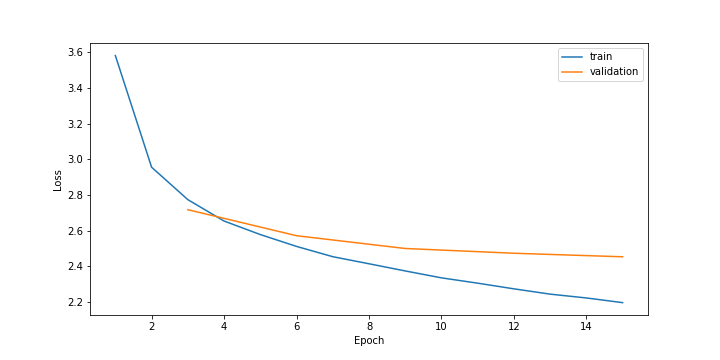

После вывода о переобучении была предпринята попытка уменьшения сложности модели. Была рассмотрена модель с меньшим количеством слоёв и меньшей размерностью вектора скрытого состояния, а также модель без начальной инициализации cell и hidden. Однако данные модели показали меньшее значение BLEU.

В ходе следующих экспериментов была рассмотрена модель с FasterRCNN вместо InceptionV3 для перевода изображения в тензоры. В данной модификации модели каждое изображение представляется в виде 3 тензоров, полученных с Feature Pyramid Network, при этом механизм внимания был применён к каждой feature map. Данные изменения в модели привели к увеличению значений метрик. Также была рассмотрена модель с механизмом внимания для 2 feature maps, полученных с InceptionV3, однако данная модель показала худший результат.

На следующем шаге было предложено добавить dropout после слоёв для перевода эмбеддингов изображения в начальный cell и hidden и после слоя attention. Ниже представлены графики для модели c FasterRCNN без dropout и с ним.

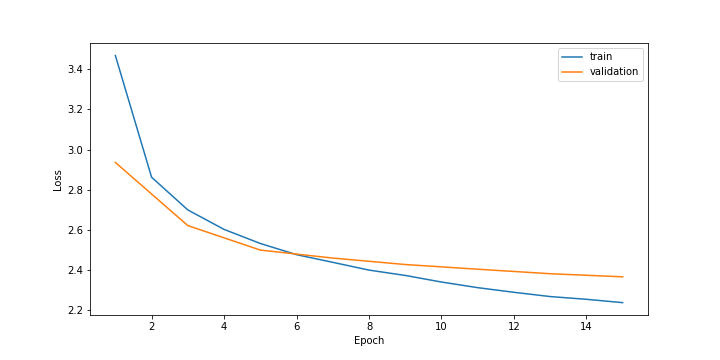

*График функции потерь для модели без dropout*

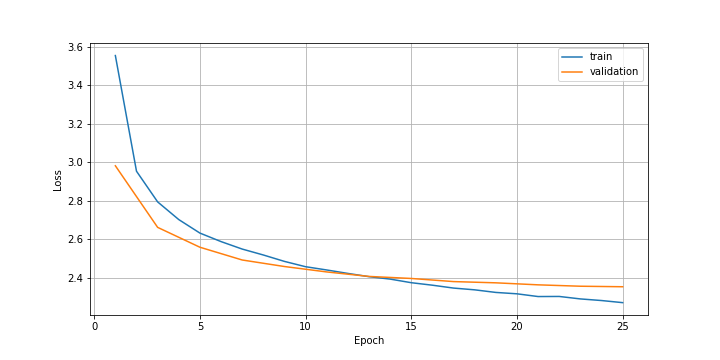

*График функции потерь для модели с dropout*

Модель с attention, FasterRCNN и dropout была выбрана в качестве итоговой и обучена в течение 25 эпох. Ниже представлены значения лосса и метрик для данной модели.

| Train loss | Наименьший validation loss | Validation BLEU | Validation ROUGE-L |
|--|--|--|--|
| 2.270627819809742 | 2.3531702198474456 | 0.2644285273103153 | 0.38063780354050414 |